# Spaceship Titanic

Predict which passengers are transported to an alternate dimension

### File and Data Field Descriptions

<details>
<summary>Click to expand</summary>

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
+ PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the 
group. People in a group are often family members, but not always.
+ HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
+ CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
+ Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
+ Destination - The planet the passenger will be debarking to.
+ Age - The age of the passenger.
+ VIP - Whether the passenger has paid for special VIP service during the voyage.
+ RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
+ Name - The first and last names of the passenger.
+ Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

+ test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
+ PassengerId - Id for each passenger in the test set.
+ Transported - The target. For each passenger, predict either True or False.

</details>

In [1]:
from datetime import datetime as time
import joblib

import matplotlib.pyplot as plt
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


plt.figure(dpi=100, figsize=(8, 5))

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [2]:
# Importing the dataset
train = pd.read_csv('data/space_train.csv')
test = pd.read_csv('data/space_test.csv')

In [3]:
# MI Scores functions

def make_mi_scores(_X, _y, _discrete_features):
    _mi_scores = mutual_info_regression(_X, _y, discrete_features=_discrete_features)
    _mi_scores = pd.Series(_mi_scores, name="MI Scores", index=X.columns)
    _mi_scores = _mi_scores.sort_values(ascending=False)
    return _mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

## Possible improvements

**Feature engineering**:
- Cabin can be transformed to deck and side
- HomePlanet can be imputed with the most frequent value
- CryoSleep can be imputed with the most frequent value
- Age can be imputed with the mean value
- VIP can be imputed with the most frequent value
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck can be imputed with the mean value
- Optional: Can be added new feature 'FamilySize' which will be sum of SibSp and Parch
- Optional: Can be added new feature 'IsAlone' which will be 1 if FamilySize is 1, otherwise 0
- Optional: Can be added new feature 'Name provided' by checking if Name is provided or not (1 or 0)

**Model tuning**:
- Hyperparameter tuning
- Feature selection
- Model selection
- Cross-validation

In [4]:
# Advanced feature engineering

def advanced_feature_engineering(df: pd.DataFrame):
    """
    Advanced feature engineering
    1. Impute missing values
    2. Add new features
    3. Drop columns
    4. Transform object columns to category
    """
    
    mean_columns = ['Age']
    imputer = SimpleImputer(strategy='mean') # impute missing numeric values by mean
    df[mean_columns] = imputer.fit_transform(df[mean_columns])
    
    frequent_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] # most frequent
    imputer = SimpleImputer(strategy='most_frequent')
    df[frequent_columns] = imputer.fit_transform(df[frequent_columns])
    
    frequent_columns = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Cabin']
    imputer = SimpleImputer(strategy='most_frequent') # Impute missing values by frequent value
    df[frequent_columns] = imputer.fit_transform(df[frequent_columns])
    
    # Split Cabin into deck/num/side, where side can be either P for Port or S for Starboard.
    df[['Deck', 'Num','Side']] = df['Cabin'].str.split('/', expand=True)
    df.drop('Cabin', axis=1, inplace=True)
    
    # Add column Name provided by empty value in column Name
    df['Name provided'] = df['Name'].notna()
    
    # add column Surname by split Name and take second part
    df['Surname'] = df['Name'].str.split(' ').str[1]
    
    # Add column FamilySize by grouping Surname and counting
    df['FamilySize'] = df.groupby('Surname')['Surname'].transform('count')
    
    # If there are no Surname, then set FamilySize to 1
    df['FamilySize'] = np.where(
        (df['FamilySize'] == 0) | (df['FamilySize'].isna()), 1, df['FamilySize']
    )
    
    # Add column IsAlone by checking FamilySize
    df['IsAlone'] = np.where(
        df['FamilySize'] == 1, 1, 0
    )
    
    # transform object columns to category
    object_columns = df.select_dtypes(include=['object']).columns
    # select only columns with less than 10 unique values
    uniq_10 = [col for col in object_columns if df[col].nunique() < 10]
    
    # transform object columns to category
    for col in uniq_10:
        df[col], _ = df[col].factorize()
    
    # drop columns which are not needed
    list_to_drop = ['PassengerId', 'Name', 'Surname']
    df = df.drop(list_to_drop, axis=1)
    
    # Seems we can drop Destination, Name provided, FamilySize and Vip columns
    columns_with_low_mi = ['Destination', 'FamilySize', 'VIP', 'Side', 'IsAlone']
    df.drop(columns_with_low_mi, axis=1, inplace=True)   
    
    return df
    

In [5]:
train_improved = advanced_feature_engineering(train)

X = train_improved.drop('Transported', axis=1)
y = train_improved['Transported']

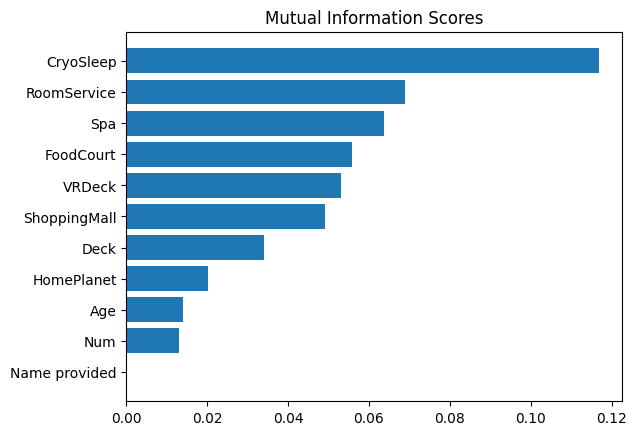

In [6]:
# Investigate MI of data

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)

plot_mi_scores(mi_scores)

In [7]:
# prepare data for model
random_state = int(time.now().timestamp()) % 4294967295

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

In [8]:
from keras.src.saving import load_model
import os

# Tune model
# To tune the RandomForestClassifier with parameters, you can use GridSearchCV from sklearn.model_selection.
# This allows you to perform an exhaustive search over a specified parameter grid.
random_state = int(time.now().timestamp()) % 4294967295
MODEL_NAME = 'data/space_model.pkl'

model = None

if os.path.exists(MODEL_NAME):
    model = joblib.load(MODEL_NAME)

if model is None:
    # Define the parameter grid
    param_grid = {
        'n_estimators': [25, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False], 
        'max_features': ['sqrt', 'log2']
    }
    
    rf_classifier = RandomForestClassifier(random_state=random_state)
    
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='neg_log_loss', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    print("Best Hyperparameters:", grid_search.best_params_)
    model = grid_search.best_estimator_
    # model = RandomForestClassifier(**{'bootstrap': False,
    #                                   'max_depth': 10,
    #                                   'max_features': 'sqrt',
    #                                   'min_samples_leaf': 2,
    #                                   'min_samples_split': 2,
    #                                   'n_estimators': 100,
    #                                   'random_state': random_state})
    # model.fit(X_train, y_train)

2024-10-04 20:56:54.307466: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 20:56:54.685228: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 20:56:55.973236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 20:56:57.895158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [9]:

train_prediction = model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,train_prediction))
# Use cross-validation to estimate performance
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Accuracy Score: 0.7939282428702852
Cross-validation scores: [0.8059816  0.80138037 0.77453988 0.81671779 0.80966999]
Mean cross-validation score: 0.8016579248454487


In [10]:
test_for_prediction = advanced_feature_engineering(test)
test_prediction = model.predict(test_for_prediction) 

In [11]:
# Save results
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': test_prediction})
output.to_csv('data/space_submission.csv', index=False)
joblib.dump(model, MODEL_NAME)
print("Your submission was successfully saved!")

AttributeError: 'RandomForestClassifier' object has no attribute 'save'